In [132]:
import pandas as pd
import os
import json

# Define the path to the output folder
output_folder = '/workspaces/cwl-data/output/structured-2018-04-08-proleague1'

# Initialize an empty list to store the data
data = []

# Loop through all files in the output folder
for filename in os.listdir(output_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(output_folder, filename)
        with open(file_path, 'r') as file:
            json_data = json.load(file)
            data.append(json_data)

# Create a DataFrame from the list of data
df = pd.DataFrame(data)

# filter only the mode = 'Hardpoint'
df = df[df['mode'] == 'Hardpoint']

# Initialize an empty list to store the transformed data
transformed_data = []

# Iterate through the DataFrame and transform the data
for index, row in df.iterrows():
    match_id = row['id']
    map_name = row['map']
    duration = row['duration_ms']
    hp_hill_names = row['hp_hill_names']
    
    for team in row['teams']:
        team_name = team['name']
        teams = row['teams']
        opponent_team_name = next(t['name'] for t in teams if t['name'] != team_name)        
        for round_index, round_score in enumerate(team['round_scores']):
            transformed_data.append({
                'match_id': match_id,
                'map': map_name,
                'duration_ms': duration,
                'team': team_name,
                'opponent_team': opponent_team_name,
                'hill_num': round_index + 1,
                'round_score': round_score,
                ## total hills = length of hp_hill_names
                'total_hills': len(hp_hill_names),
                'hill_name': hp_hill_names[hill_num] if hill_num < len(hp_hill_names) else None
            })

# Create a new DataFrame from the transformed data
transformed_df = pd.DataFrame(transformed_data)

# Display the transformed DataFrame
# print(transformed_df.head())

# Extract team scores for each hill and combine with hp_hill_names
hill_scores = []

for index, row in df.iterrows():
    match_id = row['id']
    map_name = row['map']
    duration = row['duration_ms']
    hp_hill_names = row['hp_hill_names']
    
    for team in row['teams']:
        team_name = team['name']
        round_scores = team['round_scores']
        
        for hill_num, round_score in enumerate(round_scores):
            hill_scores.append({
                'match_id': match_id,
                'map': map_name,
                'duration_ms': duration,
                'team': team_name,
                'hill_num': hill_num + 1,
                'round_score': round_score,
                ## total hills = length of hp_hill_names
                'total_hills': len(hp_hill_names),
                'hill_name': hp_hill_names[hill_num] if hill_num < len(hp_hill_names) else None
            })

# Create a new DataFrame from the hill_scores list
hill_scores_df = pd.DataFrame(hill_scores)

## rewrite hill_num to be hill_num mod total_hills
## if hill_num mod total_hills = 0, then hill_num = total_hills else hill_num = hill_num mod total_hills
hill_scores_df['hill_num_mod'] = hill_scores_df.apply(lambda row: row['hill_num'] % row['total_hills'] if row['hill_num'] % row['total_hills'] != 0 else row['total_hills'], axis=1)
## same with transformed_df
transformed_df['hill_num_mod'] = transformed_df.apply(lambda row: row['hill_num'] % row['total_hills'] if row['hill_num'] % row['total_hills'] != 0 else row['total_hills'], axis=1)

# Display the new DataFrame
print(hill_scores_df.head(10))

                               match_id                   map  duration_ms  \
0  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
1  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
2  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
3  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
4  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
5  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
6  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
7  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
8  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   
9  ab7e12d2-8217-5561-b6c8-927431692315  Sainte Marie du Mont       667000   

          team  hill_num  round_score  total_hills   hill_name  hill_num_mod  
0  RED RESERVE         1           41            4  restaurant

In [133]:
## create a new df with the average score per hill for each map + hill_name combo
average_scores = hill_scores_df.groupby(['map', 'hill_num_mod'])['round_score'].mean().reset_index().rename(columns={'round_score': 'avg_score'})

## add next_avg_score for next hill_num_mod on map, if last one, get first value
average_scores['next_hill_num_mod'] = average_scores['hill_num_mod'] + 1
average_scores['next_avg_score'] = average_scores.apply(lambda row: average_scores[(average_scores['map'] == row['map']) & (average_scores['hill_num_mod'] == row['next_hill_num_mod'])]['avg_score'].values[0] if len(average_scores[(average_scores['map'] == row['map']) & (average_scores['hill_num_mod'] == row['next_hill_num_mod'])]) > 0 else average_scores[(average_scores['map'] == row['map']) & (average_scores['hill_num_mod'] == 1)]['avg_score'].values[0], axis=1)

## drop next_hill_num_mod column

average_scores = average_scores.drop(columns=['next_hill_num_mod'])
average_scores

,map,hill_num_mod,avg_score,next_avg_score
0,Ardennes Forest,1,19.913043,17.841463
1,Ardennes Forest,2,17.841463,21.891892
2,Ardennes Forest,3,21.891892,13.457143
3,Ardennes Forest,4,13.457143,19.913043
4,Gibraltar,1,19.116162,18.917582
5,Gibraltar,2,18.917582,21.051724
6,Gibraltar,3,21.051724,20.901316
7,Gibraltar,4,20.901316,19.116162
8,London Docks,1,16.638743,19.546703
9,London Docks,2,19.546703,21.180380


In [135]:
## there are 5 seconds at the beginning of the game with no hill. 
## first left join transformed_df with itself on match_id and team = opponent_team and hill_num
add_opponent_score_df = transformed_df.merge(transformed_df[['match_id', 'team', 'opponent_team', 'hill_num','hill_num_mod', 'round_score']],
                                              how='left', left_on=['match_id', 'team', 'hill_num'], right_on=['match_id', 'opponent_team', 'hill_num'], suffixes=('', '_opponent'))

## drop opponent_team_opponent column
add_opponent_score_df = add_opponent_score_df.drop(columns=['opponent_team_opponent'])

## group by id, team cumulative sum of round_score and round_score_opponent
add_opponent_score_df['team_score'] = add_opponent_score_df.groupby(['match_id', 'team'])['round_score'].cumsum()
add_opponent_score_df['opponent_team_score'] = add_opponent_score_df.groupby(['match_id', 'team'])['round_score_opponent'].cumsum()

## millisecond into the game = hill_num*60*1000 + 5000
add_opponent_score_df['time_ms'] = add_opponent_score_df['hill_num'] * 60 * 1000 + 5000
add_opponent_score_df['time_s'] = add_opponent_score_df['time_ms'] / 1000

add_opponent_score_df.head(11)




,match_id,map,duration_ms,team,opponent_team,hill_num,round_score,total_hills,hill_name,hill_num_mod,team_opponent,hill_num_mod_opponent,round_score_opponent,team_score,opponent_team_score,time_ms,time_s
0,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,1,41,4,None,1,ERA ETERNITY,1,1,41,1,65000,65.0
1,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,2,24,4,None,2,ERA ETERNITY,2,32,65,33,125000,125.0
2,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,3,20,4,None,3,ERA ETERNITY,3,35,85,68,185000,185.0
3,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,4,9,4,None,4,ERA ETERNITY,4,19,94,87,245000,245.0
4,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,5,23,4,None,1,ERA ETERNITY,1,24,117,111,305000,305.0
5,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,6,20,4,None,2,ERA ETERNITY,2,37,137,148,365000,365.0
6,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,7,34,4,None,3,ERA ETERNITY,3,0,171,148,425000,425.0
7,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,8,19,4,None,4,ERA ETERNITY,4,19,190,167,485000,485.0
8,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,9,35,4,None,1,ERA ETERNITY,1,14,225,181,545000,545.0
9,ab7e12d2-8217-5561-b6c8-927431692315,Sainte Marie du Mont,667000,RED RESERVE,ERA ETERNITY,10,21,4,None,2,ERA ETERNITY,2,26,246,207,605000,605.0


In [136]:
only_time_df = add_opponent_score_df[['match_id','duration_ms','map','team']].drop_duplicates().reset_index(drop=True)
only_time_df.loc[:,'time_s'] = round(only_time_df.loc[:,'duration_ms'] / 1000)

only_time_df.head()
expanded_time_df = only_time_df.loc[only_time_df.index.repeat(only_time_df['time_s'] + 1)]
expanded_time_df['time_s'] = expanded_time_df.groupby(['match_id','team']).cumcount()

## add hill_num, which is 0 for the first 5s, then modulo 60s
expanded_time_df['hill_num'] = (expanded_time_df['time_s'] - 5) // 60 + 1

## reset index
expanded_time_df = expanded_time_df.reset_index(drop=True)

# expanded_time_df.head(75)


# ## check to make sure each id has a different time_s
# expanded_time_df.groupby('id').agg({'time_s': 'max'}).head()
# Expand the DataFrame to include a row for both teams within the team json column
expanded_time_df = expanded_time_df.merge(
    add_opponent_score_df[['match_id', 'team', 'hill_num','hill_num_mod', 'team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']],
    how='left',
    on=['match_id', 'hill_num','team']
)

# # Forward fill the scores to fill in the NaN values
# expanded_time_df[['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']] = expanded_time_df[['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']].fillna(method='ffill')

expanded_time_df.sort_values(by=['match_id', 'time_s']).head(75)

,match_id,duration_ms,map,team,time_s,hill_num,hill_num_mod,team_score,opponent_team_score,round_score,round_score_opponent
200266,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,MINDFREAK,0,0,NaN,NaN,NaN,NaN,NaN
200922,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,RED RESERVE,0,0,NaN,NaN,NaN,NaN,NaN
200267,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,MINDFREAK,1,0,NaN,NaN,NaN,NaN,NaN
200923,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,RED RESERVE,1,0,NaN,NaN,NaN,NaN,NaN
200268,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,MINDFREAK,2,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
200301,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,MINDFREAK,35,1,1.0,44.0,5.0,44.0,5.0
200957,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,RED RESERVE,35,1,1.0,5.0,44.0,5.0,44.0
200302,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,MINDFREAK,36,1,1.0,44.0,5.0,44.0,5.0
200958,0161b997-3912-5c43-ac9d-3eb29540ebc4,655000,Sainte Marie du Mont,RED RESERVE,36,1,1.0,5.0,44.0,5.0,44.0


In [137]:
test_add_opponent_score_df = add_opponent_score_df[add_opponent_score_df['match_id'] == 'ab7e12d2-8217-5561-b6c8-927431692315']
test_expanded_time_df = expanded_time_df[expanded_time_df['match_id'] == 'ab7e12d2-8217-5561-b6c8-927431692315']



In [138]:
test_expanded_time_df

,match_id,duration_ms,map,team,time_s,hill_num,hill_num_mod,team_score,opponent_team_score,round_score,round_score_opponent
0,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,RED RESERVE,0,0,NaN,NaN,NaN,NaN,NaN
1,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,RED RESERVE,1,0,NaN,NaN,NaN,NaN,NaN
2,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,RED RESERVE,2,0,NaN,NaN,NaN,NaN,NaN
3,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,RED RESERVE,3,0,NaN,NaN,NaN,NaN,NaN
4,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,RED RESERVE,4,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1331,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,ERA ETERNITY,663,11,3.0,245.0,250.0,38.0,4.0
1332,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,ERA ETERNITY,664,11,3.0,245.0,250.0,38.0,4.0
1333,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,ERA ETERNITY,665,12,NaN,NaN,NaN,NaN,NaN
1334,ab7e12d2-8217-5561-b6c8-927431692315,667000,Sainte Marie du Mont,ERA ETERNITY,666,12,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_1897/3910267541.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_expanded_time_df['round_score'] = test_expanded_time_df['round_score'].fillna(method='ffill')


<Axes: xlabel='time_s', ylabel='team_score_now'>

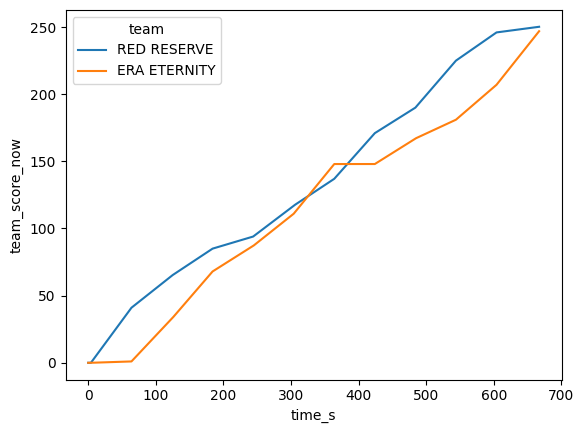

In [111]:
## if time_s = 0, then team_score = 0, opponent_team_score = 0, round_score = 0, round_score_opponent = 0
test_expanded_time_df.loc[test_expanded_time_df['time_s'] == 0, ['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']] = 0

# ffill round_score 
test_expanded_time_df['round_score'] = test_expanded_time_df['round_score'].fillna(method='ffill')

## create a new col for team_score_now = cumsum(round_score / 60)
test_expanded_time_df['team_score_now'] = test_expanded_time_df.groupby(['match_id', 'team'])['round_score'].cumsum() / 60

# test_expanded_time_df.head(40)
## plot the team_score_now by team_s
import matplotlib.pyplot as plt
import seaborn as sns


sns.lineplot(data=test_expanded_time_df, x='time_s', y='team_score_now', hue='team')


In [112]:
## add column team_score_in_30s = lead(team_score_now, 30s)
test_expanded_time_df.loc[:,'team_score_in_30s'] = test_expanded_time_df.groupby(['match_id', 'team'])['team_score_now'].shift(-30)
## coalesce team_score_in_30s with last team_score_now
test_expanded_time_df.loc[:,'team_score_in_30s'] = test_expanded_time_df['team_score_in_30s'].fillna(test_expanded_time_df.groupby(['match_id', 'team'])['team_score_now'].transform('last')).reset_index(drop=True)

## now select only match_id, team, time_s, team_score_now, team_score_in_30s
test_expanded_time_df_filter = test_expanded_time_df[['match_id', 'team', 'map', 'hill_num', 'time_s', 'team_score_in_30s']]

In [113]:
# Add a new column for time left in hill
test_expanded_time_df_filter.loc[:,'time_left_in_hill'] = 60 - ((test_expanded_time_df_filter['time_s'] - 5) % 60)

## join in average hill time
test_expanded_time_df_filter = test_expanded_time_df_filter.merge(average_scores, how='left', left_on=['map', 'hill_num'], right_on=['map', 'hill_num'])
# test_expanded_time_df_filter

# average_scores['next_avg_score'] = average_scores.groupby('map')['avg_score'].shift(-1).fillna(method='ffill')
test_expanded_time_df_filter


/tmp/ipykernel_1897/2535366620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_expanded_time_df_filter.loc[:,'time_left_in_hill'] = 60 - ((test_expanded_time_df_filter['time_s'] - 5) % 60)


,match_id,team,map,hill_num,time_s,team_score_in_30s,time_left_in_hill,avg_score,next_avg_score
0,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,Sainte Marie du Mont,0,0,17.766667,5,NaN,NaN
1,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,Sainte Marie du Mont,0,1,18.450000,4,NaN,NaN
2,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,Sainte Marie du Mont,0,2,19.133333,3,NaN,NaN
3,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,Sainte Marie du Mont,0,3,19.816667,2,NaN,NaN
4,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,Sainte Marie du Mont,0,4,20.500000,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1331,ab7e12d2-8217-5561-b6c8-927431692315,ERA ETERNITY,Sainte Marie du Mont,11,663,246.900000,2,NaN,NaN
1332,ab7e12d2-8217-5561-b6c8-927431692315,ERA ETERNITY,Sainte Marie du Mont,11,664,246.900000,1,NaN,NaN
1333,ab7e12d2-8217-5561-b6c8-927431692315,ERA ETERNITY,Sainte Marie du Mont,12,665,246.900000,60,NaN,NaN
1334,ab7e12d2-8217-5561-b6c8-927431692315,ERA ETERNITY,Sainte Marie du Mont,12,666,246.900000,59,NaN,NaN


In [50]:
test_add_opponent_score_df
# Merge test_add_opponent_score_df with expanded_time_df on match_id and time_s
score_per_second_df = test_expanded_time_df.merge(
    test_add_opponent_score_df[['match_id', 'time_s', 'team','hill_num', 'team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']],
    how='left',
    left_on=['id', 'time_s', 'team', 'hill_num'], 
    right_on=['match_id', 'time_s','team', 'hill_num'],
    suffixes=('', '_y')
)

## if time_s = 0, then fill the team_score and opponent_team_score with 0
score_per_second_df.loc[score_per_second_df['time_s'] == 0, ['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']] = 0

# Forward fill the scores to fill in the NaN values
score_per_second_df[['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']] = score_per_second_df[['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']].fillna(method='ffill')

# Display the resulting DataFrame
score_per_second_df.head(20)


/tmp/ipykernel_35641/2923379252.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  score_per_second_df[['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']] = score_per_second_df[['team_score', 'opponent_team_score', 'round_score', 'round_score_opponent']].fillna(method='ffill')


,id,duration_ms,time_s,hill_num,match_id,team,match_id_y,team_score,opponent_team_score,round_score,round_score_opponent
0,ab7e12d2-8217-5561-b6c8-927431692315,667000,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,ab7e12d2-8217-5561-b6c8-927431692315,667000,1,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,ab7e12d2-8217-5561-b6c8-927431692315,667000,2,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,ab7e12d2-8217-5561-b6c8-927431692315,667000,3,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,ab7e12d2-8217-5561-b6c8-927431692315,667000,4,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
5,ab7e12d2-8217-5561-b6c8-927431692315,667000,5,1,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,NaN,0.0,0.0,0.0,0.0
6,ab7e12d2-8217-5561-b6c8-927431692315,667000,5,1,ab7e12d2-8217-5561-b6c8-927431692315,ERA ETERNITY,NaN,0.0,0.0,0.0,0.0
7,ab7e12d2-8217-5561-b6c8-927431692315,667000,6,1,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,NaN,0.0,0.0,0.0,0.0
8,ab7e12d2-8217-5561-b6c8-927431692315,667000,6,1,ab7e12d2-8217-5561-b6c8-927431692315,ERA ETERNITY,NaN,0.0,0.0,0.0,0.0
9,ab7e12d2-8217-5561-b6c8-927431692315,667000,7,1,ab7e12d2-8217-5561-b6c8-927431692315,RED RESERVE,NaN,0.0,0.0,0.0,0.0
